# Math 134A Week 3

In [1]:
import math
from scipy.optimize import fsolve
import numpy_financial as npf
import pandas as pd

# Computing the present value of a cash flow with interest rate r. 
def PV(r, cf, continuous_compounding = False, dt = None): 
    if dt is None: dt = range(len(cf))
    pv = 0
    if not continuous_compounding:
        for k in range(0, len(cf)):
            pv += cf[k] / (1+r)**dt[k]
    else:
        for k in range(0, len(cf)):
            pv += cf[k] * math.exp(-r * dt[k])
    return pv

# This will return the future value of a cash flow at time T. If T is not specified, then we take T as the time that we receive the last cash flow
def FV(r, cf, continuous_compounding = False, dt = None, T = None):
    if dt is None: dt = range(len(cf))
    if T is None: T = dt[-1]
    fv = 0
    if not continuous_compounding:
        for k in range(0, len(cf)):
            fv += cf[k] * (1+r)**(T - dt[k])
    else:
        for k in range(0, len(cf)):
            fv += cf[k] * math.exp(r * (T - dt[k]))
    return fv   

# Computing the internal rate of return by using the fsolve function to find roots to a polynomial
def irr(cf):
    def simple_npv(r, cf):
        return sum(cf[k]/(1+r)**k for k in range(len(cf)))
    
    result = fsolve(simple_npv, x0 = 0.1, args = cf)
    return result[0]

# Computing the internal rate of return by using the irr function in numpy financial library
def irr2(cf):
    return npf.irr(cf)

# This function computes the YTM of a bond mature in dt years, with face value F, price P, and coupon c paid m times every year
def YTM(F, P, dt, c = 0, m = 1):
    cf = [-P] + [c/m] * (dt * m - 1) + [F+c/m]
    return irr(cf) * m
    
# This function computes the price of a bond mature in dt years, with face value F, YTM y, and yearly coupon c paid m times every year 
def bond_price(F, y, dt, c = 0, m = 1):
    cf = [0] + [c/m] * (dt * m - 1) + [F+c/m]
    return PV(y/m, cf)

def macaulay_duration(c, y, m, n):
    """
    c is the coupon rate per period
    y is the yield per period
    m is the number of periods per year
    n is the number of periods remaining
    """
    D = (1+y)/(m*y) - (1 + y + n*(c-y))/(m*c * ((1+y)**n - 1) + m*y)
    return D
    

## Example of fixed income securities
- **Certificate of Deposit (CD)**
- Government securities: 
  - **U.S. Treasury bills**
  - **U.S. Treasury notes** 
  - **U.S. Treasure bonds**
- **Municipal bonds**
- **Corporate bonds**

## Example of other fixed income investment
- **Annuity**
- **Mortgages**

The above two fixed income investments are usually not considered as a security since they are usually not traded on markets. 


## Annuity
A **perpetual annuity** pays a fixed amount A at the end of every period forever. Its corresponding cash flow is $(0, A, A, A,\ldots)$. Suppose that the prevailing interest per period is $r$. The present value of this annuity is 
$$P = \sum_{k=1}^\infty \frac{A}{(1+r)^k} = A/r$$

In practice, the payment stream for an annuity has a finite lifetime. Suppose that an annuity pays a fixed amount A at the end of every period, and stops after n periodical payments. Let $r$ be the prevailling interest per period. Then the present value of this annuity is 
$$P = \sum_{k=1}^n \frac{A}{(1+r)^k} = \frac{A}{r}\left(1-\frac{1}{(1+r)^n}\right)$$

We also note that the annuity formula can be used in a reverse way to compute the monthly payment to a loan (which is usually called **amortization**). In this case, $P$ and $r$ are given, which are the amount of money we borrowed, and $r$ is the loan rate per period. Then $A$ is the monthly payment to the loan. We can solve that 
$$A = \frac{r(1+r)^nP}{(1+r)^n - 1}$$

In [3]:
def loan_payment(P, r, n):
    return (P * r)/(1 - 1/(1+r)**n)

## Example
Suppose you have borrowed 1000 from a credit union. The loan has a yearly interest 12\% compounded monthly. You are to make equal monthly payments to repay the loan over 6 months. How much is the monthly payment?

In [3]:
monthly_payment = loan_payment(1000, 0.01, 6)
print(f"The monthly payment for the loan is {monthly_payment:.2f}")

The monthly payment for the loan is 172.55


In [4]:
import pandas as pd

pd.set_option('float_format', '{:.2f}'.format)
data = pd.DataFrame()
data['Month'] = [1, 2, 3, 4, 5, 6]
previous_balance = [1000]
current_interest = [1000 * 0.01]
payment = [monthly_payment] * 6
net_balance = [1000 * 1.01 - monthly_payment]
for i in range(1, 6):
    previous_balance.append(net_balance[-1])
    current_interest.append(previous_balance[-1] * 0.01)
    net_balance.append(previous_balance[-1] + current_interest[-1] - monthly_payment)
data['previous_balance'] = previous_balance
data['current_interest'] = current_interest
data['payment'] = payment
data['net_balance'] = net_balance
display(data)


,Month,previous_balance,current_interest,payment,net_balance
0,1,1000.00,10.00,172.55,837.45
1,2,837.45,8.37,172.55,673.28
2,3,673.28,6.73,172.55,507.46
3,4,507.46,5.07,172.55,339.99
4,5,339.99,3.40,172.55,170.84
5,6,170.84,1.71,172.55,0.00


## Example
Suppose we borrowed 30000 from a bank with fixed annual interest rate 12\%, compounded monthly, for 30 years, with monthly payment. Compute the monthly payment, and draw a graph showing the ratio of interest and principal paid over each year.

The monthly payment is 308.58


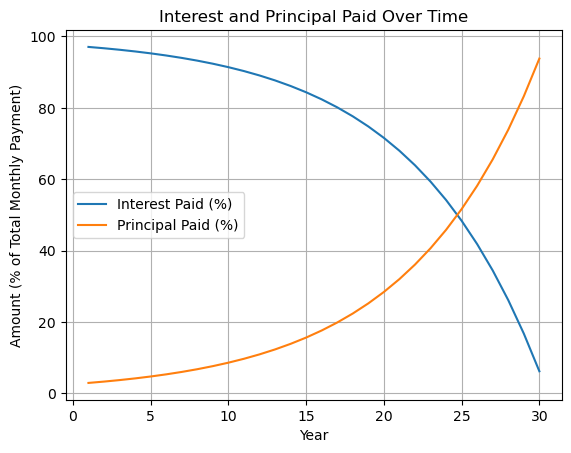

In [5]:
# Plotting percent of interest paid vs principle paid on a loan throughout the loans lifetime
import matplotlib.pyplot as plt
# Loan parameters
loan_amount = 30000
interest_rate = 0.12
loan_term_years = 30
num_payments = loan_term_years * 12
monthly_rate = interest_rate / 12
# Calculate the monthly payment
monthly_payment = loan_payment(loan_amount, monthly_rate, num_payments)
print(f"The monthly payment is {monthly_payment:.2f}")
# Initialize lists for interest, principal, and month number
interest_paid = []
principal_paid = []
year_numbers = [year + 1 for year in range(loan_term_years)]
# Calculate interest and principal payments for each year
remaining_balance = loan_amount
for year in range(loan_term_years):
    annual_interest = 0
    annual_principal = 0
    for month in range(12):
        interest = remaining_balance * monthly_rate
        principal = monthly_payment - interest
        remaining_balance -= principal
        annual_interest += interest
        annual_principal += principal
    interest_paid.append(annual_interest / (12*monthly_payment) * 100)
    principal_paid.append(annual_principal / (12*monthly_payment) * 100)
# Plot the interest and principal paid over time
plt.plot(year_numbers, interest_paid, label='Interest Paid (%)')
plt.plot(year_numbers, principal_paid, label='Principal Paid (%)')
plt.xlabel('Year')
plt.ylabel('Amount (% of Total Monthly Payment)')
plt.title('Interest and Principal Paid Over Time')
plt.legend()
plt.grid()
plt.show()

**Exercise 3.1**: (Amortization) A debt of 25,000 is to be amortized over 7 years at 7\% interest. What value of monthly payments will achieve this? Suppose that the interest is compounded monthly for calculation. 

In [6]:
print(f"The monthly payment is {loan_payment(25000, 0.07/12, 7*12):.2f}")

The monthly payment is 377.32


**Exercise 3.3**: (Uncertain annuity ) Gavin’s grandfather, Mr. Jones, has just turned 90 years old and is applying for a lifetime annuity that will pay 10,000 per year, starting 1 year from now, until he dies. He asks Gavin to analyze it for him. Gavin finds that according to statistical summaries, the chance (probability) that Mr. Jones will die at any particular age is as follows:

| age         | 90  | 91  | 92  | 93  | 94  | 95  | 96  | 97  | 98  | 99  | 100 | 101 | 
|-------------|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
| probability | .07 | .08 | .09 | .10 | .10 | .10 | .10 | .10 | .10 | .07 | .05 | .04 |

Then Gavin (and you) answer the following questions:
(a) What is the life expectancy of Mr. Jones? \
(b) What is the present value of an annuity at 8\% interest that has a lifetime equal to Mr. Jones’s life expectancy? (For an annuity of a non-integral number of years, use an averaging method.) \
(c) What is the expected present value of the annuity?

In [57]:
print(f"a) The life expectancy for Mr. Jones is {90 * 0.07 + 91 * 0.08 + 92 * 0.09 + 93 * 0.1 + 94 * 0.1 + 95 * 0.1 + 96 * 0.1 + 97 * 0.1 + 98 * 0.1 + 99 * 0.07 + 100 * 0.05 + 101 * 0.04:.2f}")

print("b) We will compute the present value of this annuity if the lifetime of Mr. Jones is 95 and 96 respectively")
cf1 = [0] + [10000] * 5
cf2 = [0] + [10000] * 6
p95 = PV(r = 0.08, cf = cf1)
p96 = PV(r = 0.08, cf = cf2)
print(f"   The PV of the annuity if Mr. Jones died at age 95 is P_95 = {p95:.2f}")
print(f"   The PV of the annuity if Mr. Jones died at age 96 is P_96 = {p96:.2f}")
print(f"   We take a weighted average 0.87 * PV_95 + 0.13 * PV_96 = {0.13 * p96 + 0.87 * p95:.2f}")

ecf = [0, 9300, 8500, 7600, 6600, 5600, 4600, 3600, 2600, 1600, 900, 400]
print(f"c) The expected present value of the annuity is computed by E[P] = (1-0.07) * 10000/1.08 + (1-0.08 - 0.07) * 10000/1.08^2 + ... 0.04 * 100000/1.08^11= {PV(0.08, ecf):.2f}")

a) The life expectancy for Mr. Jones is 95.13
b) We will compute the present value of this annuity if the lifetime of Mr. Jones is 95 and 96 respectively
   The PV of the annuity if Mr. Jones died at age 95 is P_95 = 39927.10
   The PV of the annuity if Mr. Jones died at age 96 is P_96 = 46228.80
   We take a weighted average 0.87 * PV_95 + 0.13 * PV_96 = 40746.32
c) The expected present value of the annuity is computed by E[P] = (1-0.07) * 10000/1.08 + (1-0.08 - 0.07) * 10000/1.08^2 + ... 0.04 * 100000/1.08^11= 38386.95


**Exercise 3.5**: (Mortgage restructuring) An investor purchased a small apartment building for 250,000. She made a down payment of 50,000 and financed the balance with a 30-year, fixed-rate mortgage at 12% annual interest, compounded monthly. For exactly 20 years she has made equal-sized monthly payments as required by the terms of the loan. Now she has the opportunity to restructure the mortgage by refinancing the balance. She could borrow the current balance, pay off the original loan, and assume a new loan for the balance. (No points or any other charges are involved in the transaction.) The new loan is a 20-year, fixed-rate loan at 9%, compounded monthly, to be paid in equal monthly installments. Suppose she has a risk-free savings account that pays 5%, compounded monthly. Should she restructure the mortgage?

**Solution**: 
We will first compute the monthly payment of the first mortgage. Then we compute the remaining balance at the end of year 20 by computing the present value of the remaining 10 year payment at the end of year 20 under 12\% annual interest. Then we compute the new monthly payment if we choose to reconstruct the remaining balance.

Now, we get two cash flow of payments. We will compute their present value at the end of year 20, and choose the one with smaller present value. We run the following codes to do the computation.

In [7]:
monthly_payment_old = loan_payment(200000, 0.01, 30*12)
print(f"The monthly payment of the first loan is {monthly_payment_old:.2f}")

payment_cf = [0] + [monthly_payment_old] * 20 * 12
payment_pv = PV(0.01, payment_cf)
#remaining_amount = FV(0.01, [200000-payment_pv], T= 20 * 12)
remaining_payment1_cf = [0] + [monthly_payment_old] * 10 * 12
remaining_balance = PV(0.01, remaining_payment1_cf)
print(f"The remaining balance to the first loan at the end of year 20 is {remaining_balance:.2f}")

monthly_payment_new = loan_payment(remaining_balance, 0.09/12, 20 * 12)
print(f"The new monthly payment if reconstruct the loan is {monthly_payment_new:.2f}")

remaining_payment1_cf = [0] + [monthly_payment_old] * 10 * 12
remaining_payment2_cf = [0] + [monthly_payment_new] * 20 * 12
print(f"The present value of the payments if we do not reconstruct the loan is {PV(0.05/12, remaining_payment1_cf):.2f} at the end of year 20")
print(f"The present value of the payments if we reconstruct the loan is {PV(0.05/12, remaining_payment2_cf):.2f} at the end of year 20")
print("Hence, we choose not to restructure the loan")


The monthly payment of the first loan is 2057.23
The remaining balance to the first loan at the end of year 20 is 143389.67
The new monthly payment if reconstruct the loan is 1290.11
The present value of the payments if we do not reconstruct the loan is 193957.97 at the end of year 20
The present value of the payments if we reconstruct the loan is 195484.94 at the end of year 20
Hence, we choose not to restructure the loan


# Bonds

A **bond** is an obligation by the bond issuer to pay money to the bondholder according to rules specified at the time the bond is issued. Generally, a bond pays a specific amount, its **face value** or, equivalently, its **par value** at the date of maturity. Most bonds pay periodic coupon payments, which is usually a fraction of its face value. We call the internal rate of return of bond as its **yield to maturity (YTM)**. Given the YTM of a bond, we can also compute its price by calculating the present value of the bond's payment cashflow.

The U.S. Treasury bills does not pay coupon. The "interest" is the difference between its face value and price you paid.

**Example**
Here is a table of the recent auction result of the 52-week U.S. Treasury bill. We can compute the YTM of the following bills. 

In [3]:
data = pd.read_csv("../data/52_week_bill.csv")
data.head(5)

,CUSIP,Security Type,Security Term,Auction Date,Issue Date,Maturity Date,Price per $100
0,912797KS5,Bill,52-Week,04/16/2024,04/18/2024,04/17/2025,95.030389
1,912797KJ5,Bill,52-Week,03/19/2024,03/21/2024,03/20/2025,95.136556
2,912797KA4,Bill,52-Week,02/20/2024,02/22/2024,02/20/2025,95.252833
3,912797JR9,Bill,52-Week,01/23/2024,01/25/2024,01/23/2025,95.379222
4,912796ZV4,Bill,52-Week,12/26/2023,12/28/2023,12/26/2024,95.353944


In [5]:
print(f"The YTM for the first bill is {irr([-95.03, 100])*100:.2f}%")

The YTM for the first bill is 5.23%


**Example**
Consider the following auction result for a 3-year U.S. Treasury note. Verify the YTM from the price, and the price from the YTM

![3-year note aucton result](../img/3_year_note_auction.png)

In [14]:
cf = [-99.8668, 2.25, 2.25, 2.25, 2.25, 2.25, 102.25]
print(f"The YTM of this bond computed from its price is {2 * irr(cf) * 100:.3f}%")

cf2 = [0, 2.25, 2.25, 2.25, 2.25, 2.25, 102.25]
r = 0.04548/2
print(f"The price of this bond computed from its YTM is {PV(r, cf2):.4f}")

The YTM of this bond computed from its price is 4.548%
The price of this bond computed from its YTM is 99.8668


In [101]:
print(f"The YTM computed from the price is {YTM(P = 99.8668, F = 100, c = 4.5, dt = 3, m = 2) * 100:.3f}%")
print(f"The price computed from the YTM is {bond_price(F = 100, y = 0.04548, c = 4.5, dt = 3, m = 2):.4f}")

The YTM computed from the price is 4.548%
The price computed from the YTM is 99.8668


**Exercise 3.7**: 
(Callable bond) The Z Corporation issues a 10%, 20-year bond at a time when yields are 10%. The bond has a call provision that allows the corporation to force a bondholder to redeem his or her bond at face value plus 5%. After 5 years the corporation finds that exercise of this call provision is advantageous. What can you deduce about the yield at that time? (Assume one coupon payment per year.)

**Solution:** \
The remaining cashflow after 5 years is $[0, 10, 10, \ldots, 10, 110]$. Since the company find it advantageous to call back the bond, then the price of the bond after year 5 is at least 105. Hence, the yield of the bond after year 5 is at most the irr of the cash flow $[-105, 10, 10,\ldots, 10, 110]$, which is 9.366\%. We conclude that YTM$\leq 9.366 \%$

In [4]:
cashflow = [-105] + [10] * 14 + [110]
print(f"The irr of the above cashflow is {irr(cashflow)*100:.3f}%")

The irr of the above cashflow is 9.366%


**Exercise 3.13**: 
(Bond price) An 8% bond with 18 years to maturity has a yield of 9%. What is the price of this bond?

In [10]:
cf = [0] + [4] * (18 * 2 - 1) + [104]
print("The cash flow of payment of this bond is", cf)
r = 0.045
print(f"The price of this bond is {PV(r, cf):.2f}")

The cash flow of payment of this bond is [0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 104]
The price of this bond is 91.17


## Bond Duration
In bond analysis, it is common to use yield instead of the interest rate. Duration measures the bond's sensitivity to changes in yield, which relates directly to price. There are two commonly used types of duration: **Macaulay duration** and **modified duration**. 

Macaulay duration is the weighted average time to receive the bond's cash flows, considering the yield. Suppose a financial instrument makes payments $m$ times per year, with the payment in period being $c_k$, and there are $n$ periods remaining. The Macaulay duration is defined as:
$$D = \frac{\sum_{k=1}^n \frac{k}{m}\frac{c_k}{(1+\lambda/m)^k}}{P}$$

Denote $P_k$ to be the present value of payment $c_k$ received in the period $k$. Then we have $P_k = \frac{c_k}{(1+\lambda/m)^k}$. Hence, we may write $D$ as 
$$D = \frac{\sum_{k=1}^n \frac{k}{m}P_k}{P}$$

Note that we also have $\frac{dP_k}{d\lambda} = -\frac{k}{m(1+\lambda/m)}P_k$. Let $P$ be the present value of the payment cashflow, which is also the price of the bond. Then we have $P = P_1+\cdots+P_k$, and thus 
$$\frac{dP}{d\lambda} = \sum_1^n \frac{dP_k}{d\lambda} = \sum_1^n\frac{-\frac{k}{m} P_k}{1+\lambda/m} = \frac{-D\cdot P}{1+\lambda/m} = -D_MP$$
We call $D_M = \frac{D}{1+\lambda/m}$ as the **modified duration**. Roughly speaking
$$\frac{\Delta P}{P} \approx -D_M\Delta \lambda$$

In the case where all coupon payments are identical (the normal case for bonds), there is an explicit formula for the Macaulay duration. For a bond with a coupon rate $c$ per period, yield $y$ per period, $m$ periods per year, and exactly $n$ periods remaining, the Macaulay duration is:
$$D = \frac{1+y}{my}-\frac{1+y+n(c-y)}{mc[(1+y)^n - 1] + my}$$

**Example**: 
Consider a bond with YTM 10%, and modified duration being 10 years. If the YTM increase to 11%, what can we say about the price of this bond

a) Increase by 1% \
b) Decrease by 1% \
c) Increase by 10% \
d) Decrease by 10%

**Solution:** The price of this bond will decrease by 10%.

**Exercise 3.14**: 
(Duration) Find the price and duration of a 10-year, 8% bond that is trading at a yield of 10%. Assume that the coupon is paid semi-annually.

In [13]:
print(f"The duration is {macaulay_duration(c = 0.04, y = 0.05, m = 2, n = 20):.2f} years")

The duration is 6.84 years


**Example**
Show that for a zero-coupon bond, its duration equals to its time to maturity.